<a href="https://colab.research.google.com/github/Olfa-Jerbi/Advanced-Data-Analysis/blob/main/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Let's start by importing the needed packages as well as mounting the drive to connect to the Datasets:**
**데이터셋에 연결하기 위해 드라이브를 장착하고 필요한 패키지를 가져오는 것부터 시작하겠습니다.**

In [ ]:
# prompt: pandas

import pandas as pd
import re
import pprint as pp

import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from textblob import TextBlob, Word
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.font_manager as fm
import math
import statistics
import numpy as np
import scipy.stats
from statistics import median
from statistics import mode
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, QuantileTransformer


**We first mount the drive to be able to access the datasets.**
**데이터셋에 액세스할 수 있도록 드라이브를 먼저 마운트합니다.**

In [ ]:
from google.colab import drive # mount Google Drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


**We here upload the training and test dataset**
**여기에  데이터 세트를 업로드합니다**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/kaggle/train.csv', encoding='utf-8')
test = pd.read_csv('/content/drive/MyDrive/kaggle/test.csv', encoding='utf-8')
train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**We then drop the Id variable and start exploring the dataset**
**그런 다음 Id 변수를 삭제하고 데이터셋 탐색을 시작합니다**

In [ ]:
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

<Axes: >

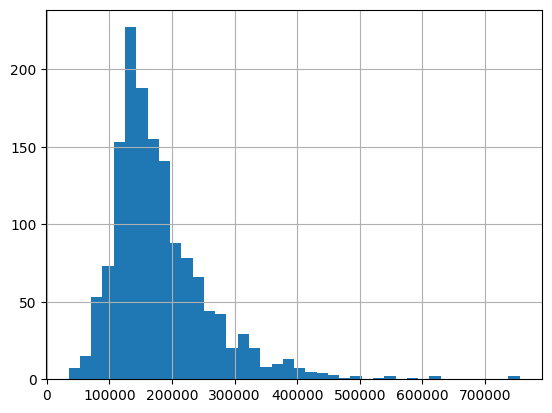

In [ ]:
train['SalePrice'].hist(bins = 40)

In [ ]:

print("The mean of houses' sales prices:", np.round(np.mean(train['SalePrice']), 3))
print("The median of houses' sales prices:", median(train['SalePrice']))
print("The mode of houses' sales prices:", mode(train['SalePrice']))


The mean of houses' sales prices: 180921.196
The median of houses' sales prices: 163000.0
The mode of houses' sales prices: 140000


**Observing the histogram above, we can notice that the distribution of houses' sales prices are not uniformely distributed where this is more highlighted by the disparity between the mean, mode and the median values. For Left-Skewed data the Mean > Median > Mode, which is the case we have in hand.**

**위의 히스토그램을 보면, 우리는 평균, 최빈값과 중앙값의 차이로 인해 주택의 매매가격의 분포가 균일하게 분포되어 있지 않다는 것을 알 수 있다. Left-Swed 자료의 경우, 평균 > 중앙값 > 최빈값, 즉 우리가 가지고 있는 경우이다.**

**Most of the statistical models do not work when the data is skewed. The reason behind this is that the tapering ends or the tail region of the skewed data distributions are the outliers in the data and it is known to us that outliers can severely damage the performance of a statistical model.**
*As a results we first start with fixing the skewness*.

**대부분의 통계적 모형은 데이터가 비대칭일 때 작동하지 않는다. 그 이유는 데이터 분포의 가늘어짐 끝 부분이나 꼬리 부분이 데이터의 이상치이고 이상치가 통계적 모형의 성능을 심각하게 손상시킬 수 있다고 알려져 있기 때문이다.**
*결과적으로 우리는 먼저 왜도를 고치는 것부터 시작한다*.

To do so in python most frequently used methods are PowerTransformer and QuantileTransformer. Both these methods are used to get a normal or Gaussian-like distribution. Now let us see how to use these methods.

파이썬에서 가장 많이 사용되는 방법은 '파워트랜스포머'와 '퀀텀트랜스포머'이다. 이 두 방법 모두 정규 분포나 가우시안과 같은 분포를 얻는 데 사용된다. 이제 이 방법들을 어떻게 사용하는지 알아보자.

Text(0.5, 1.0, 'Original Distribution')

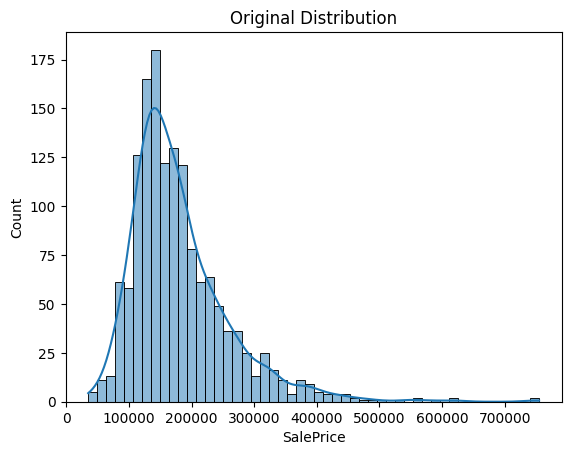

In [ ]:
#Building the PowerTransformer and QuantileTransformer to our data
pt = PowerTransformer()
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
y = pt.fit(np.array(train['SalePrice'].values.reshape(-1, 1)))
x = qt.fit(np.array(train['SalePrice'].values.reshape(-1, 1)))

#Plot the original data
sns.histplot(train['SalePrice'], bins = 50, kde = True)
plt.title(f"Original Distribution")


Text(0.5, 1.0, 'Quantile Transform')

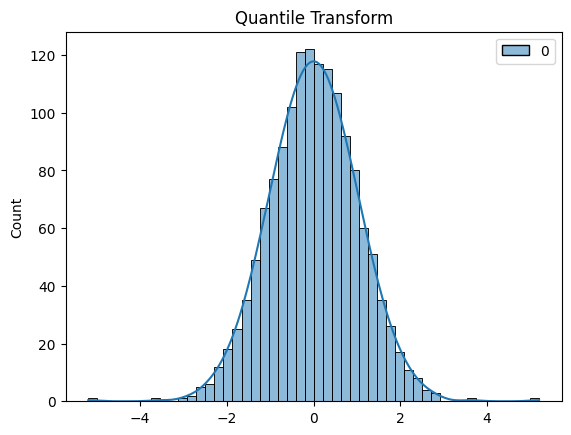

In [ ]:
#Fitting the PowerTransformer and QuantileTransformer to our data
x = qt.fit_transform(np.array(train['SalePrice'].values.reshape(-1, 1)))
y = pt.fit_transform(np.array(train['SalePrice'].values.reshape(-1, 1)))

#Plot the Quantile Tran
sns.histplot(x, bins = 50, kde = True)
plt.title(f"Quantile Transform")


Text(0.5, 1.0, 'Power Transform ')

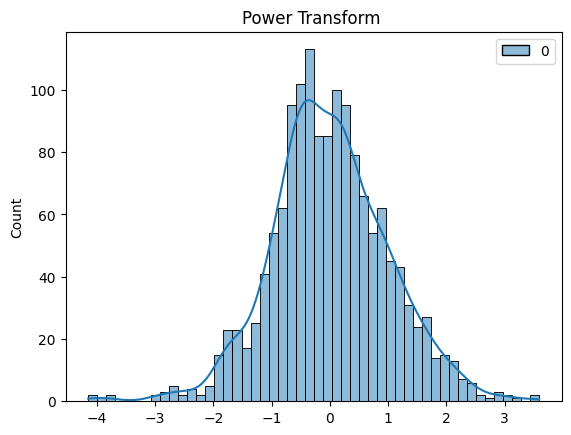

In [ ]:
#Plot the Power Tran
sns.histplot(y, bins = 50, kde = True)
plt.title(f"Power Transform ")

**Observing the three histograms above we can deduce that the Quantile Transformation works better for our case.**
**위의 3개의 히스토그램을 관찰하면 분위수 변환이 우리의 경우에 더 효과적이라는 것을 추론할 수 있습니다.**

**As a result, we guard this method for fixing the data skewness.**
**결과적으로 데이터의 왜도를 고치기 위해 이 방법을 지킵니다.**

**Let's see how our dataset looks now**

**이제 데이터 세트가 어떻게 생겼는지 확인해 보겠습니다 **

In [ ]:
train.head()
#print(train['SalePrice'])

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**We now drop the "SalePrice" variable and observe the features.**

**이제 "  SalePrice" 변수를 삭제하고 특징을 관찰합니다.**

In [ ]:
train_features = train.drop(['SalePrice'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [ ]:
features.shape

(2917, 79)

**We start by processing the variables that are not numerical.**

**숫자가 아닌 변수를 처리하는 것부터 시작합니다.**

In [ ]:
# Since these column are actually a category , using a numerical number will lead the model to assume  that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)



## Filling these columns With most suitable value for these columns
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features["PoolQC"] = features["PoolQC"].fillna("None")



## Filling these with MODE , i.e. , the most frequent value in these columns .
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [ ]:
### Missing data in GarageYrBit most probably means missing Garage , so replace NaN with zero .

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')


### Same with basement

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

In [ ]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))
print(objects)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [ ]:
# We are still filling up missing values
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))
numerics[1:10]

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF']

In [ ]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,12,2008,WD,Normal


**After handling the non numerical variables we now choose the most important features or in other words the variables that are most determinative for our goal.**

**숫자가 아닌 변수를 처리한 후, 이제 가장 중요한 특징, 즉 목표에 가장 결정적인 변수를 선택합니다.**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/kaggle/train.csv', encoding='utf-8')
train_df.set_index('Id', inplace=True)
corrmat = train_df.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>=0.3]
top_corr_features

<ipython-input-56-cfe50f6214c2>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train_df.corr()


Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

**We trace the Heatmap observed bellow where we keep the variables that have a correlation of higher than 0.3 with the variables "SalePrice".**


**Heatmap 관측 벨로우즈를 추적하여 0.3 이상의 상관관계를 갖는 변수와 "SalePrice" 변수를 유지합니다.**

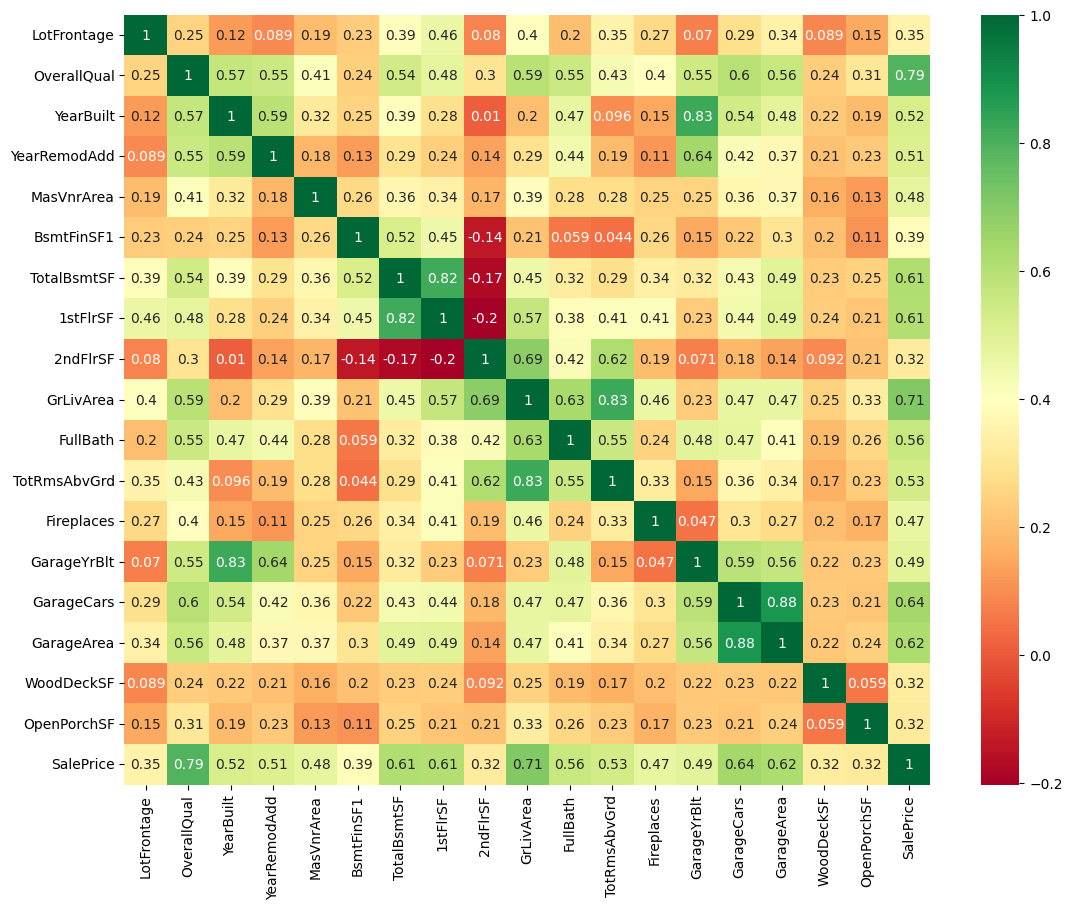

In [ ]:
# heatmap
plt.figure(figsize=(13,10))
g = sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We keep the chosen variables here.

선택한 변수는 여기에 보관합니다.

In [ ]:
features=features[['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF']]

In [ ]:
features.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,65.0,7,2003,2003,196.0,706.0,856.0,856,854,1710,2,8,0,2003.0,2.0,548.0,0,61
1,80.0,6,1976,1976,0.0,978.0,1262.0,1262,0,1262,2,6,1,1976.0,2.0,460.0,298,0
2,68.0,7,2001,2002,162.0,486.0,920.0,920,866,1786,2,6,1,2001.0,2.0,608.0,0,42
3,60.0,7,1915,1970,0.0,216.0,756.0,961,756,1717,1,7,1,1998.0,3.0,642.0,0,35
4,84.0,8,2000,2000,350.0,655.0,1145.0,1145,1053,2198,2,9,1,2000.0,3.0,836.0,192,84


In [ ]:
#Seperate train and test datasets
len_train_df = len(train_df)
train_y_label = train['SalePrice']
train_df = features[:len_train_df]
test_df = features[len_train_df:]

train_df['SalePrice'] = train_y_label

print('train set length: ',len(train_df))
print('test set length: ',len(test_df))

train set length:  1460
test set length:  1459


<ipython-input-60-464f444ebb76>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['SalePrice'] = train_y_label


In [ ]:
from sklearn.model_selection import train_test_split

X_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_test = test_df
test_id_idx = test_df.index

In [ ]:
print('X_train : ',len(X_train))
print('X_val : ',len(X_val))
print('X_test :',len(X_test))

X_train :  1168
X_val :  292
X_test : 1459


In [ ]:
#Check if all our variables are numerical
features_df = features.select_dtypes(include='object')
print('Object type columns:\n',features_df.columns)

Object type columns:
 Index([], dtype='object')


In [ ]:
#Train our model
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.7, 'colsample_bytree': 1, 'max_depth': 4, 'n_estimators': 600}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.7, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)


**Here we observe the evaluation scores.**

**여기서 평가 점수를 관찰합니다.**

In [ ]:
#Observe the evaluation scores

from sklearn.metrics import mean_squared_error, mean_absolute_error
pred_train = grid_search.predict(X_train)
pred_val = grid_search.predict(X_val)

print('train mae score: ', mean_absolute_error(y_train, pred_train))
print('val mae score:', mean_absolute_error(y_val, pred_val))

train mae score:  248.2438229077483
val mae score: 21551.690657106163


**We also plot the validation data to be able to compare the actual and the predicted data.**

**실제 데이터와 예측 데이터를 비교할 수 있도록 검증 데이터도 표시합니다.**

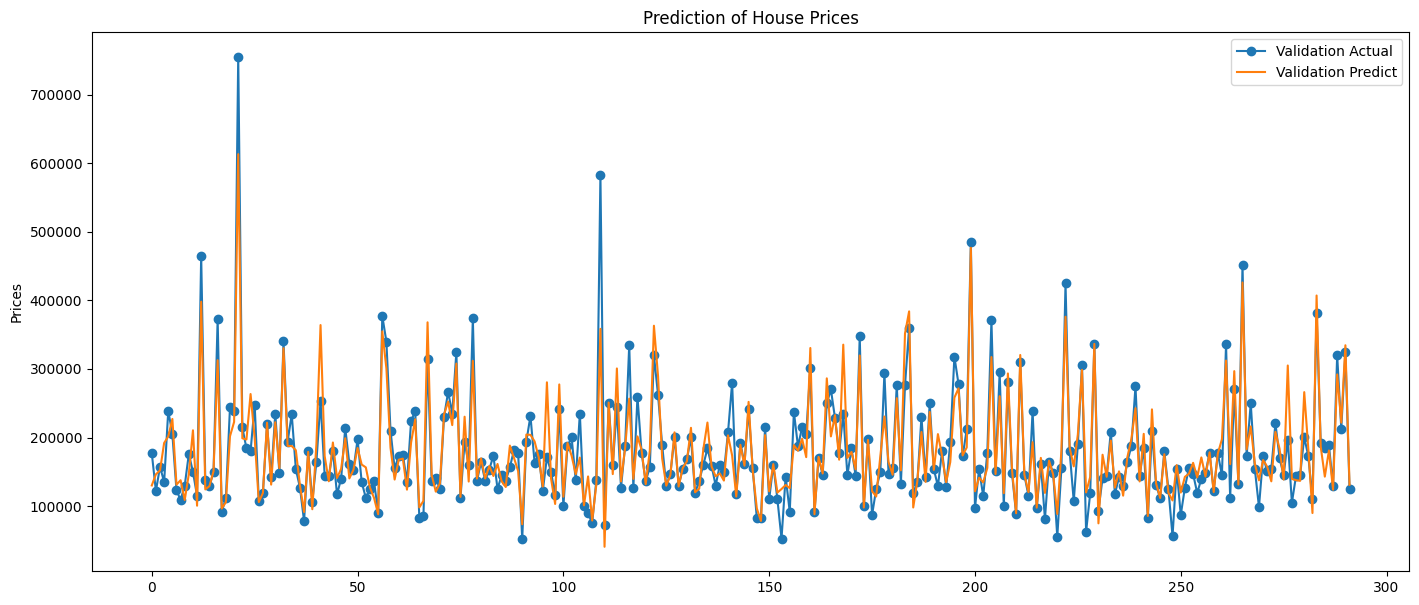

In [ ]:
plt.figure(figsize=(17,7))
plt.plot(range(0, len(y_val)), y_val,'o-', label='Validation Actual')
plt.plot(range(0, len(pred_val)), pred_val, '-', label='Validation Predict')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

In [ ]:
test_y_pred = grid_search.predict(X_test)

**We now use the build model to predict the "SalePrice" for the test dataset.**

**이제 빌드 모델을 사용하여 테스트 데이터 세트의 "SalePrice"을 예측합니다.**

In [ ]:
id_pred_df = pd.DataFrame()
id_pred_df['Id'] = test_id_idx
id_pred_df['SalePrice'] = test_y_pred


**We now save the "Submission" file to the drive.**

**이제 "Submission" 파일을 드라이브에 저장합니다.**

In [ ]:
id_pred_df.to_csv('/content/drive/My Drive/kaggle/submission.csv', index=False)

**The obtained score was 0.16223 with the rank 3416/5003.**

**획득 점수는 0.16223으로 3416/5003의 순위를 기록했습니다.**